# Lesson 21 - Model interpretation
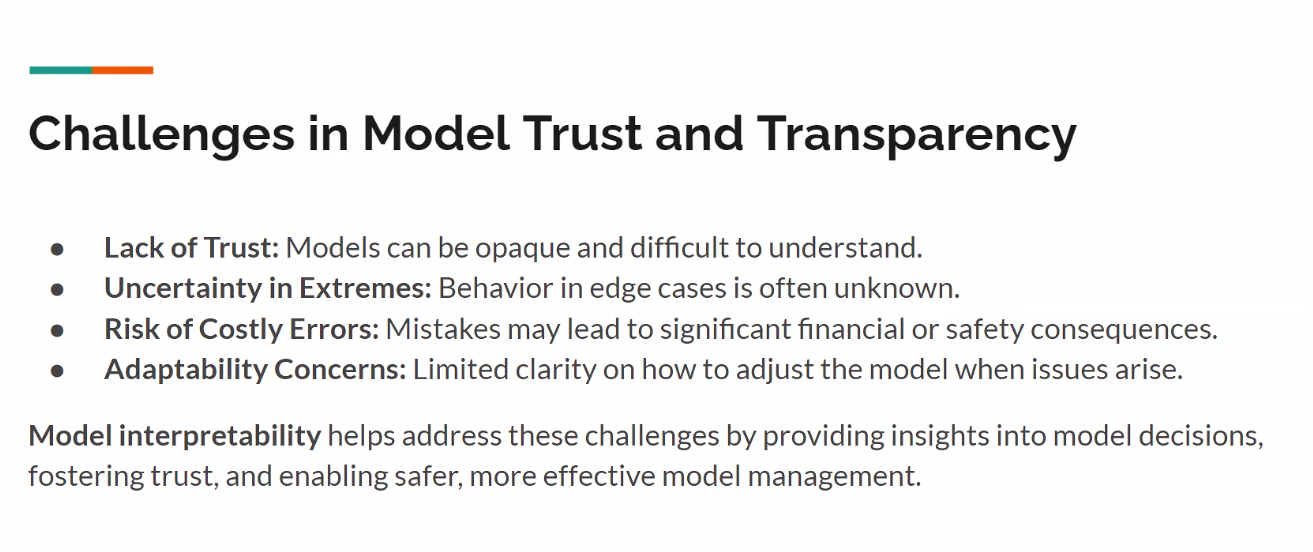

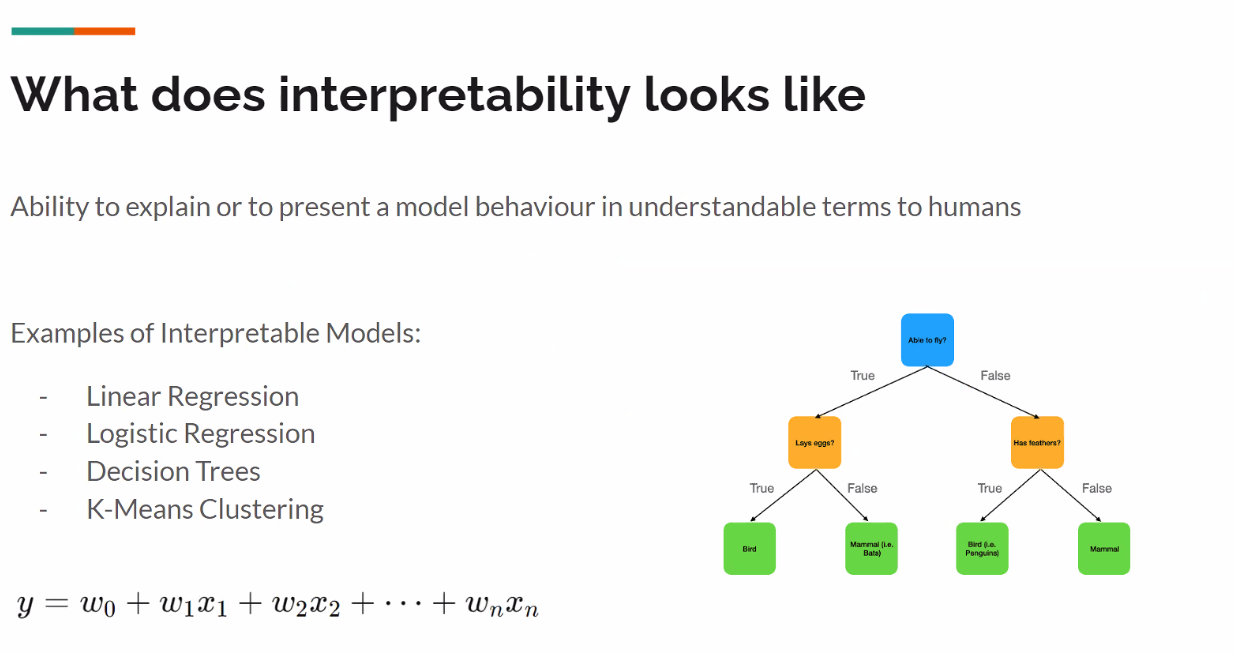

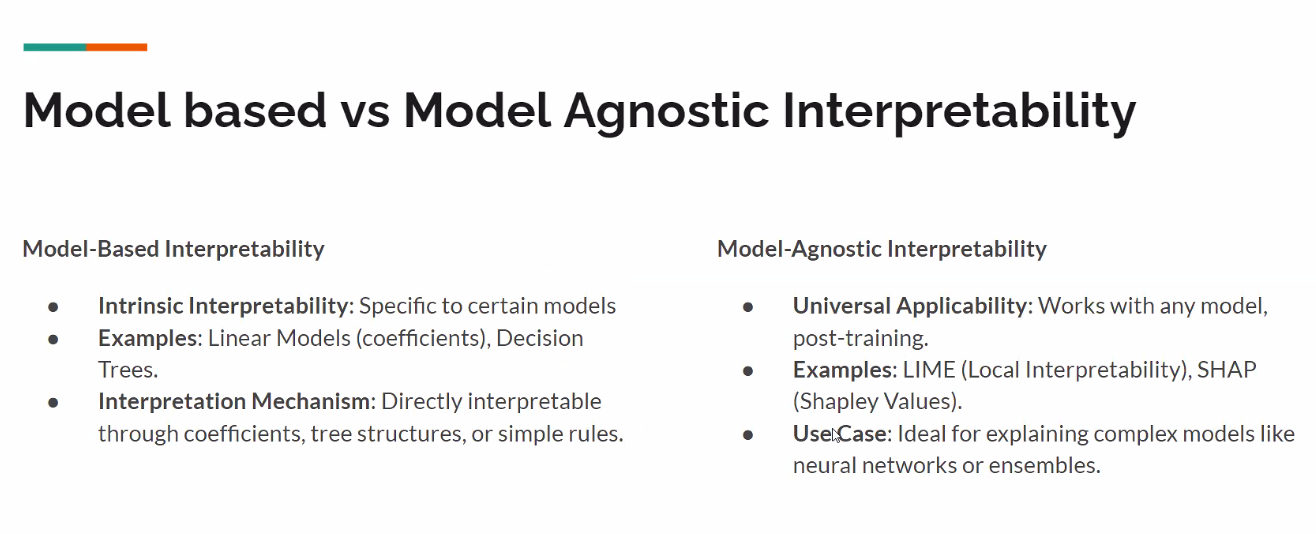

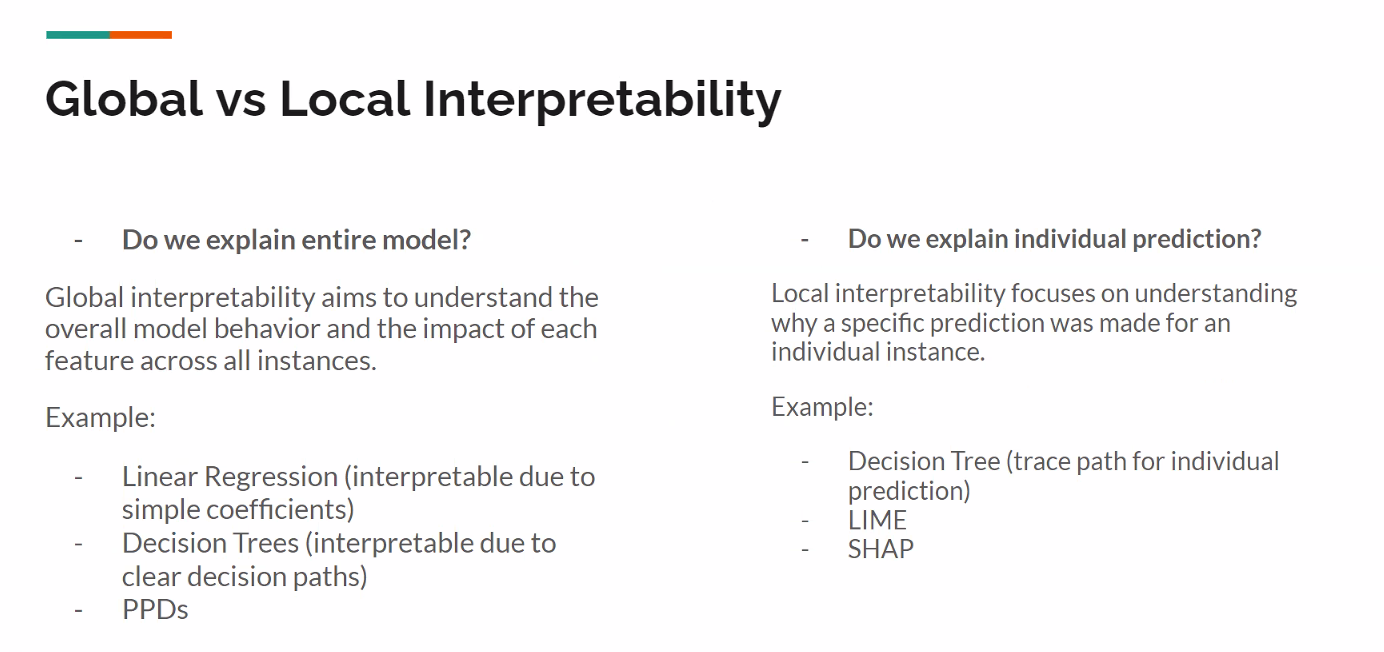

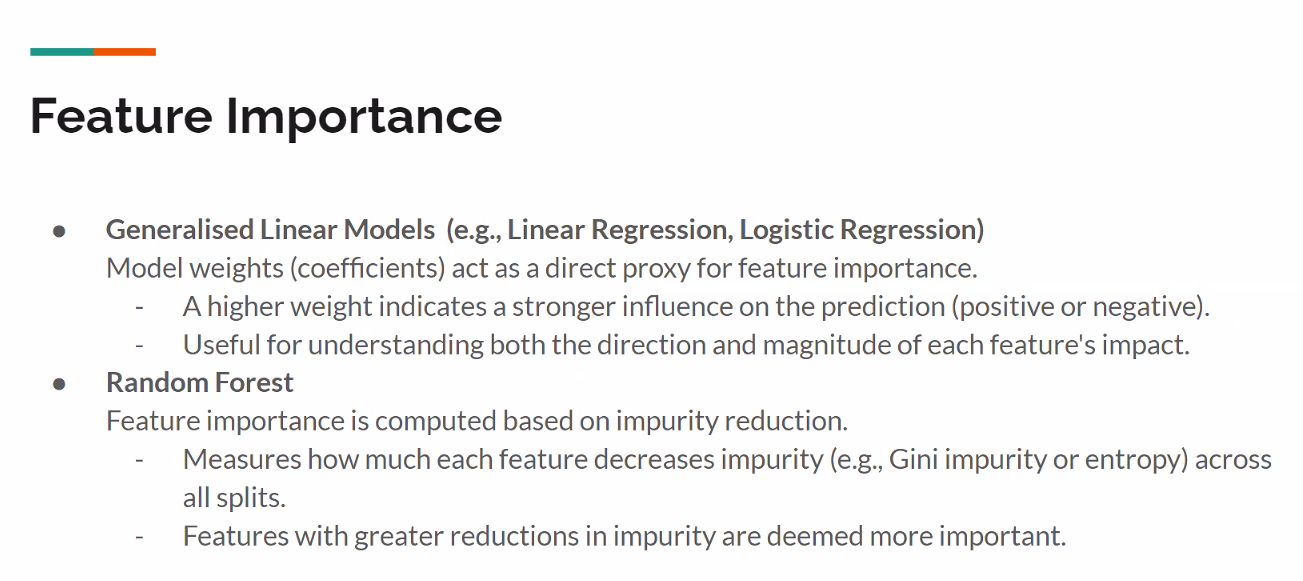

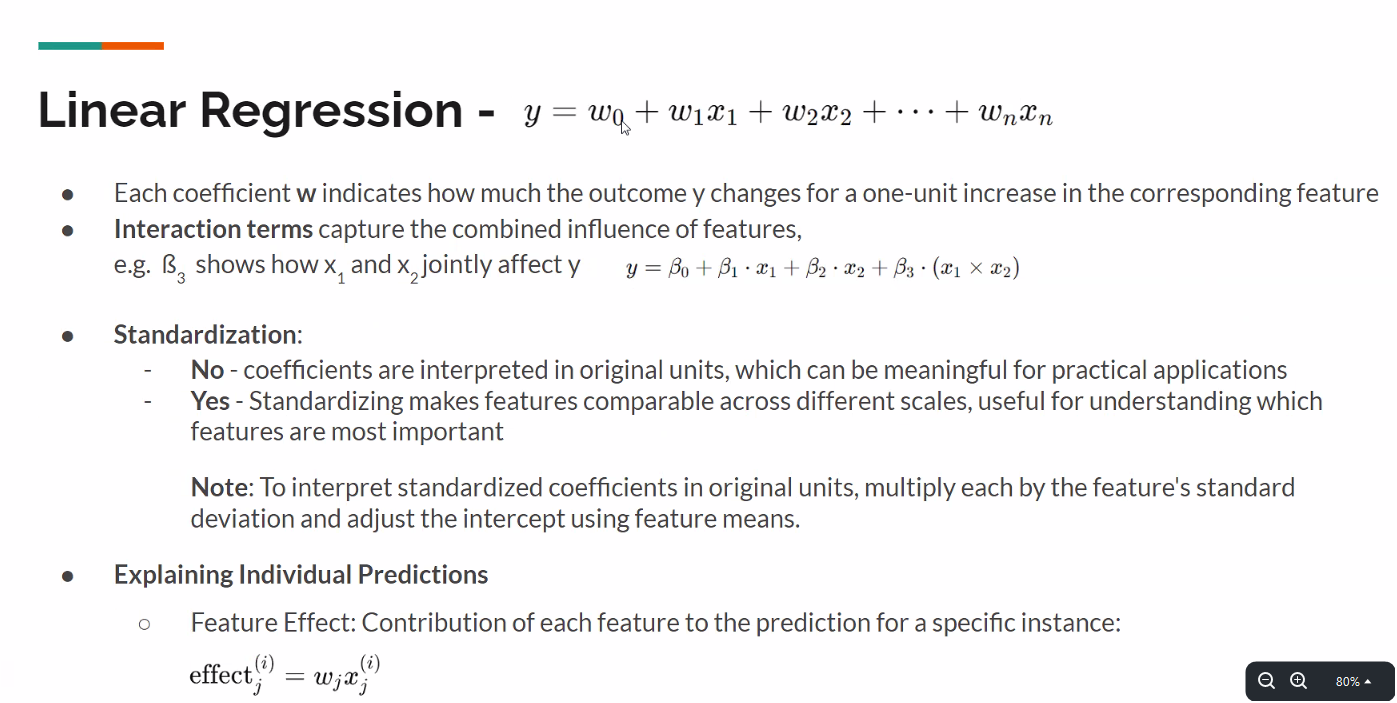

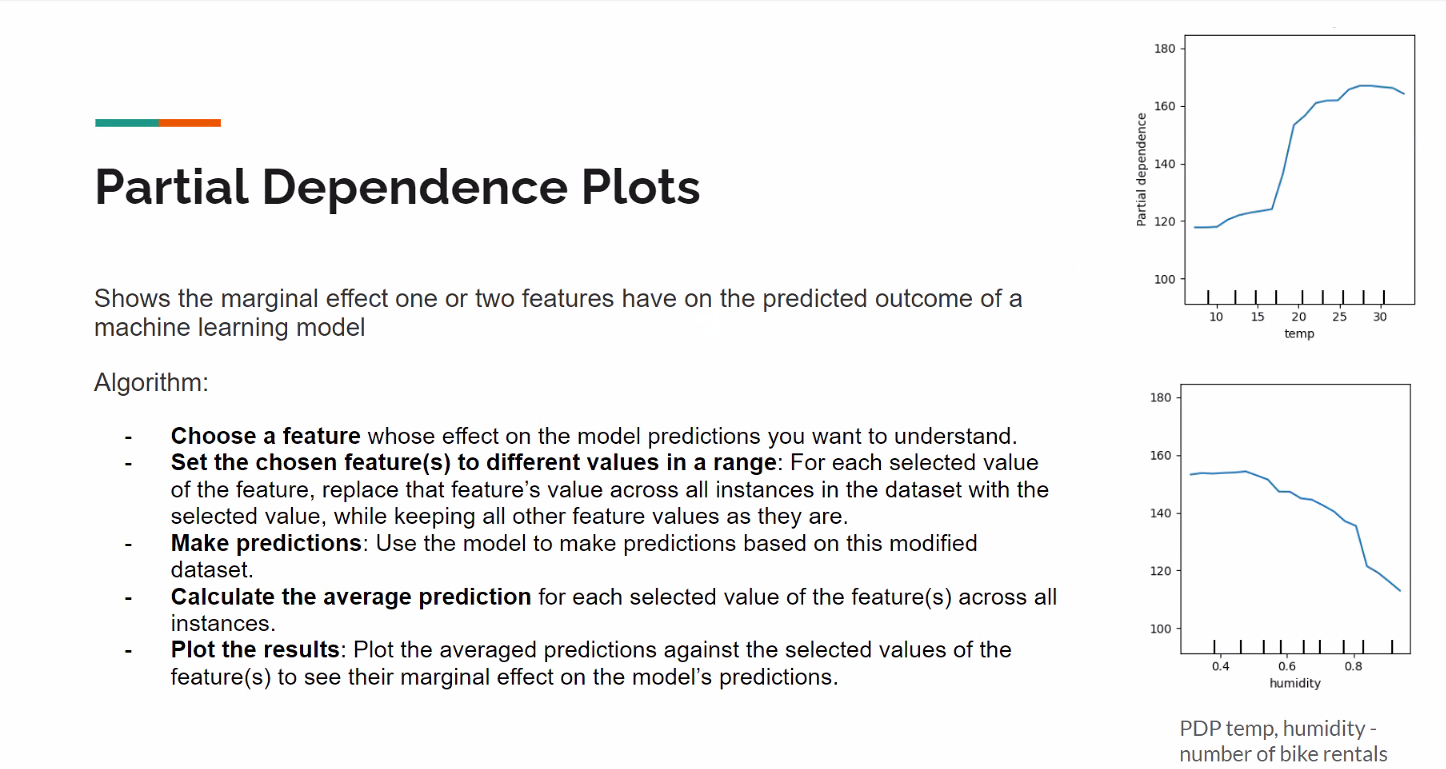

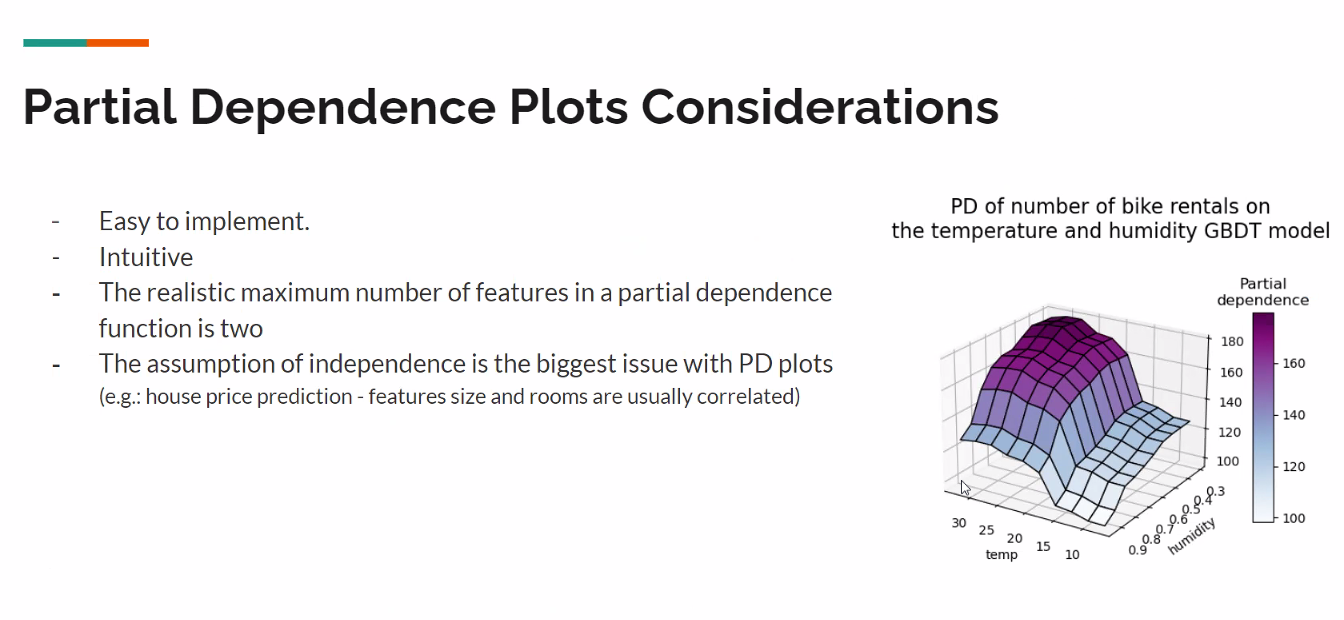

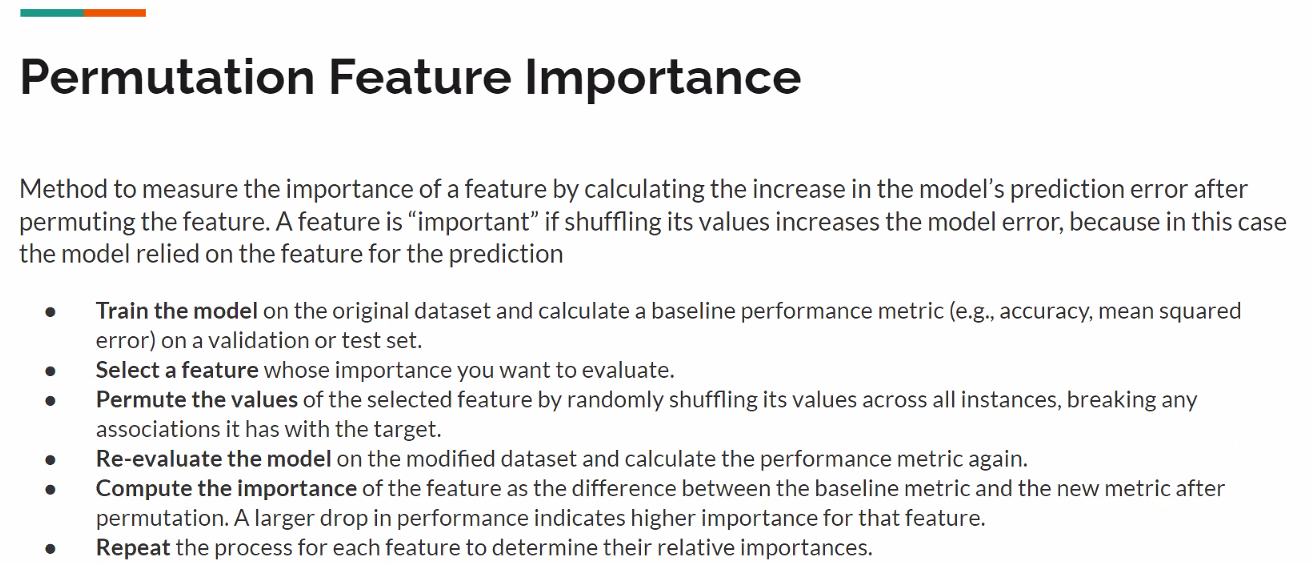

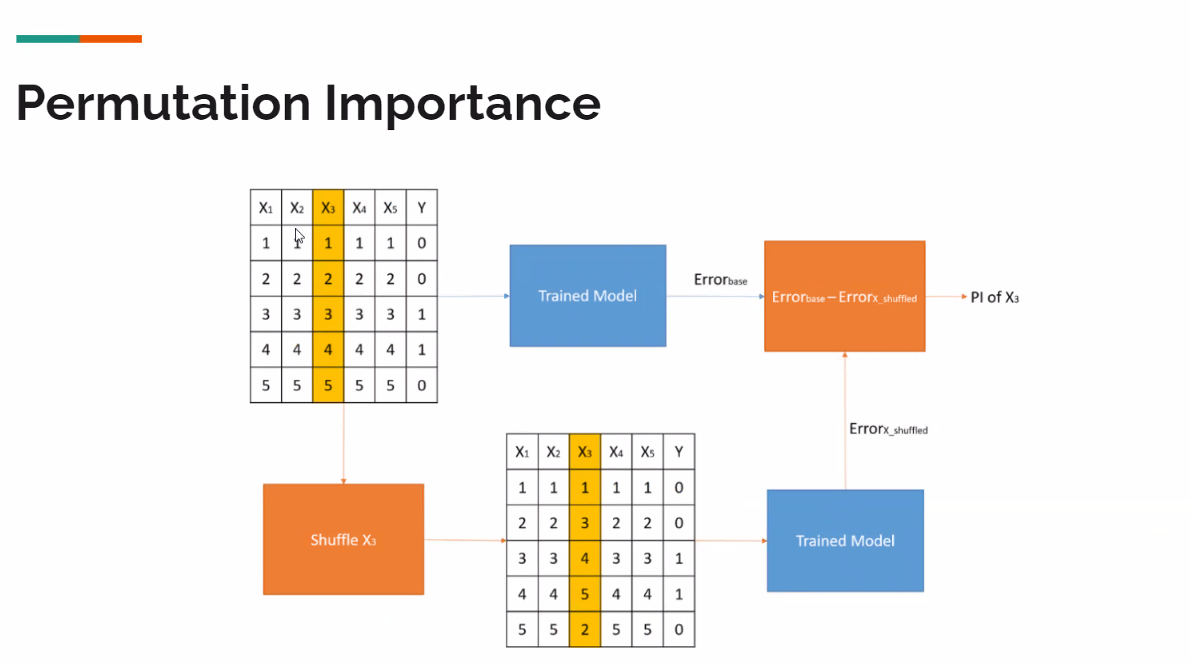

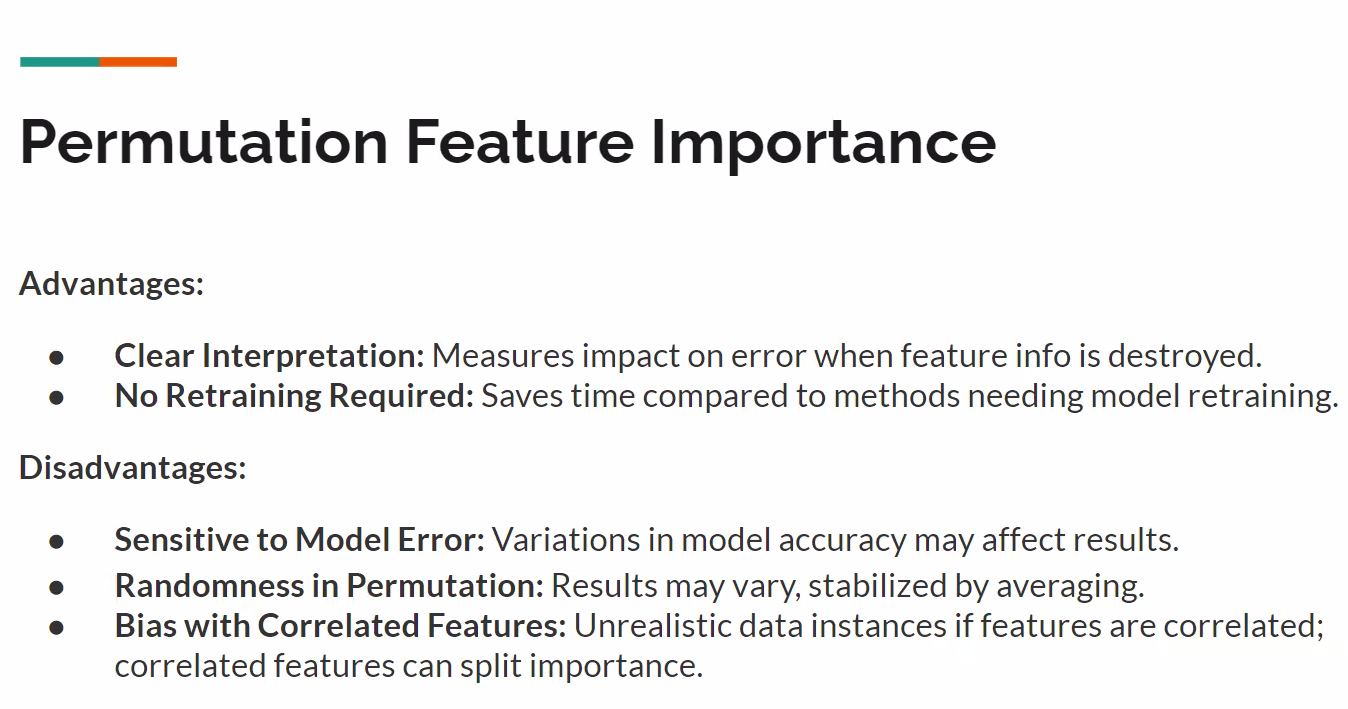

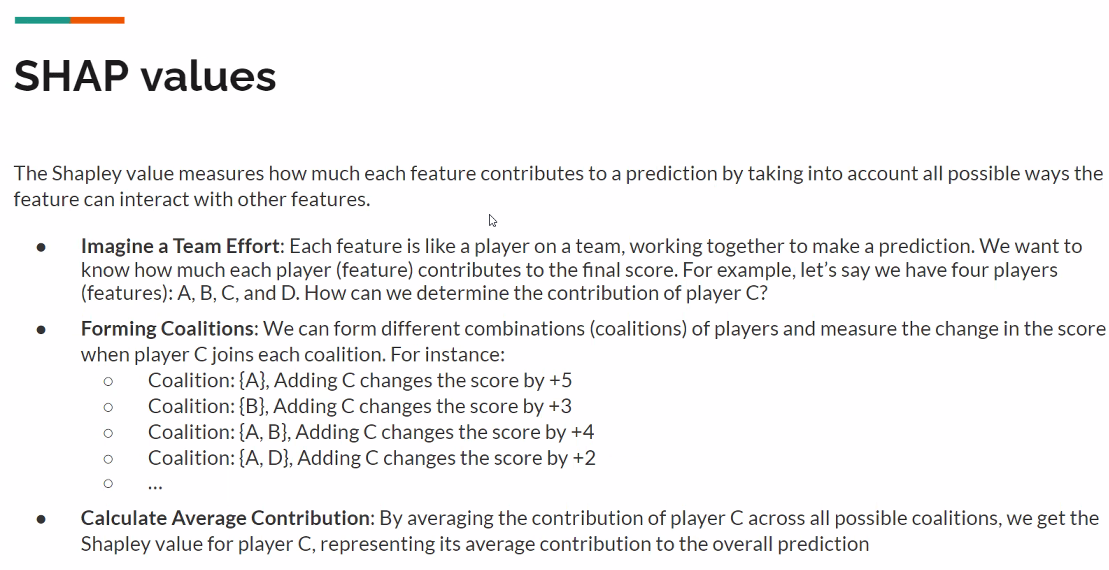

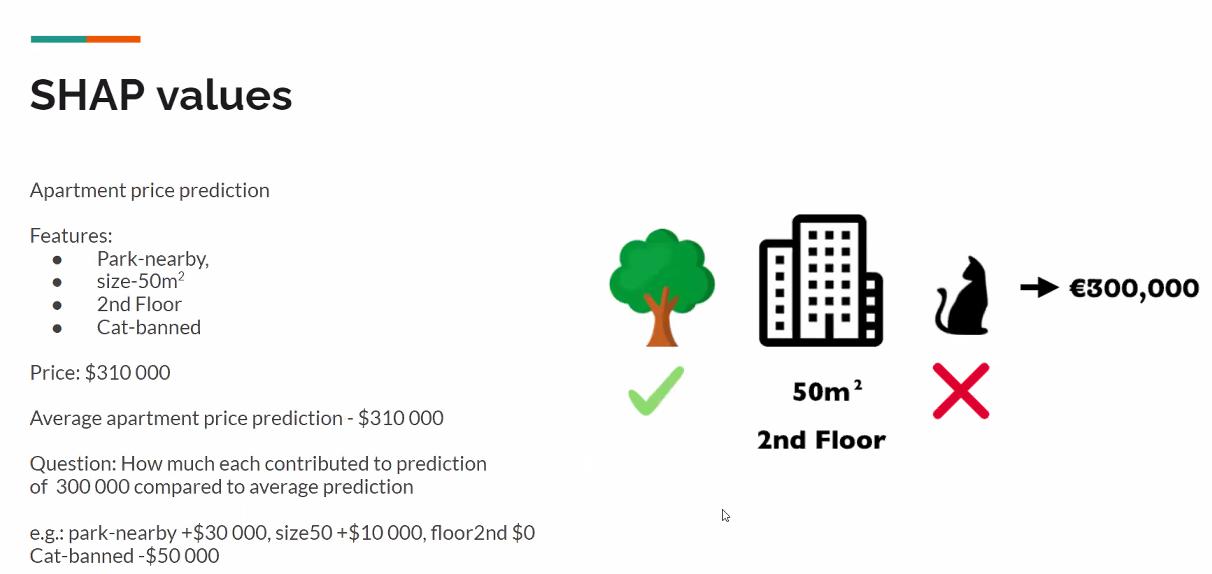

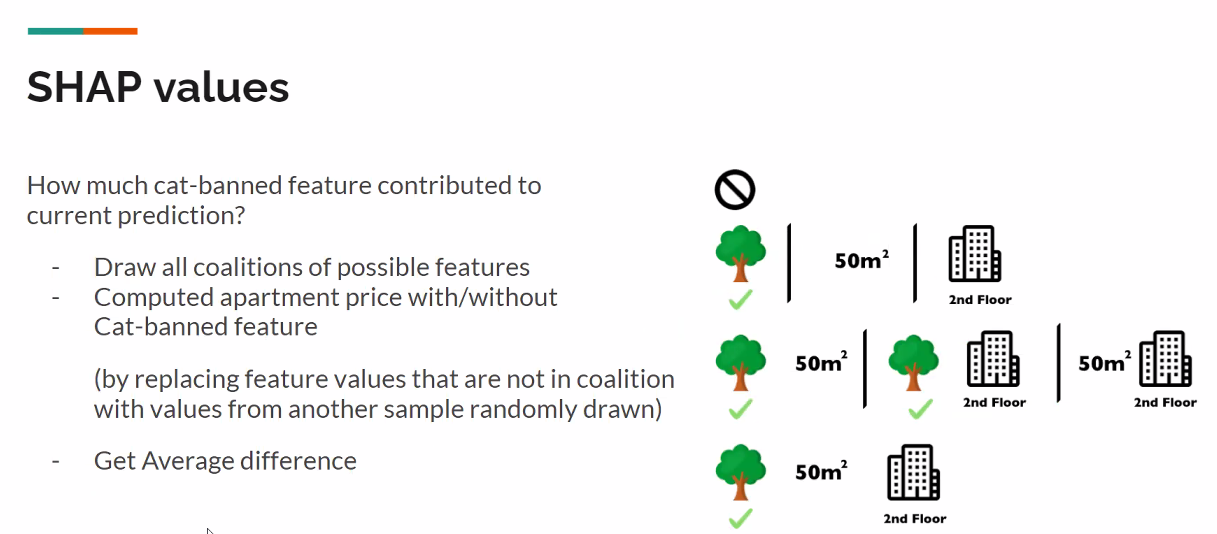

## Searching for parameters
### Red - the score is better
### blue - the score is worse
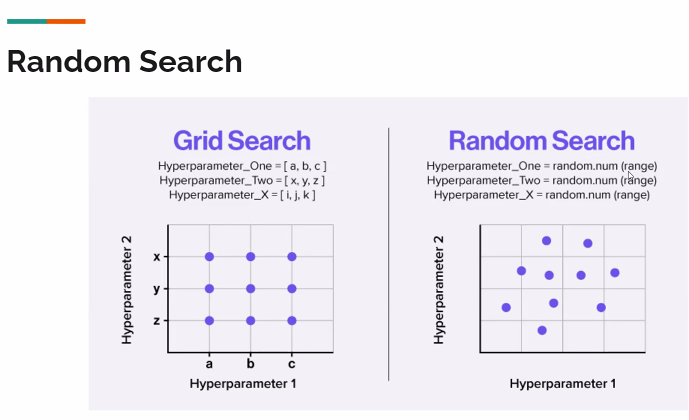
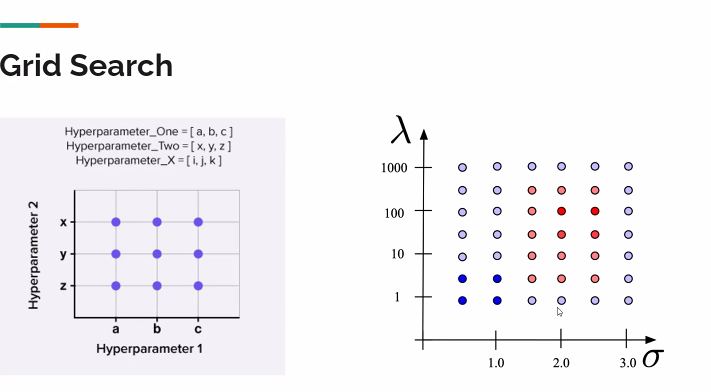
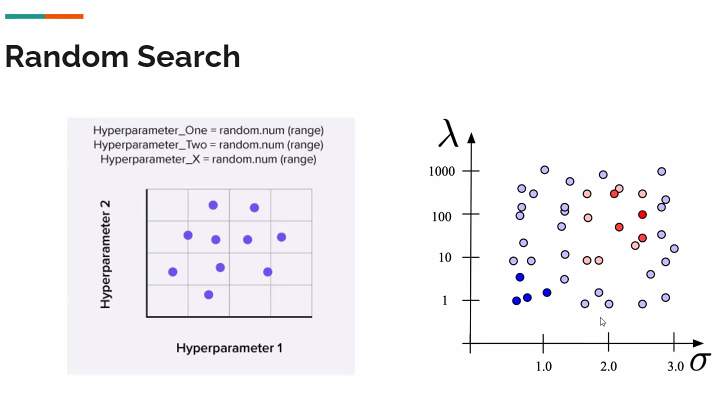

###
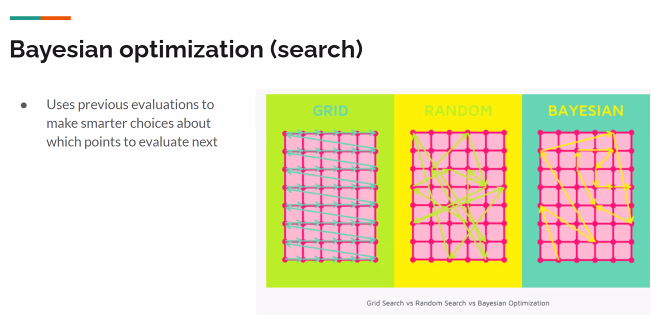

In [3]:
import numpy as mp
import pandas as pd


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/red-wine-quality-cortez-et-al-2009")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\uvang\.cache\kagglehub\datasets\uciml\red-wine-quality-cortez-et-al-2009\versions\2


In [5]:
path = fr'D:\Programming\excalibur\data\winequality-red.csv'
df = pd.read_csv(path)

In [6]:
df.quality.value_counts()

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64

[]

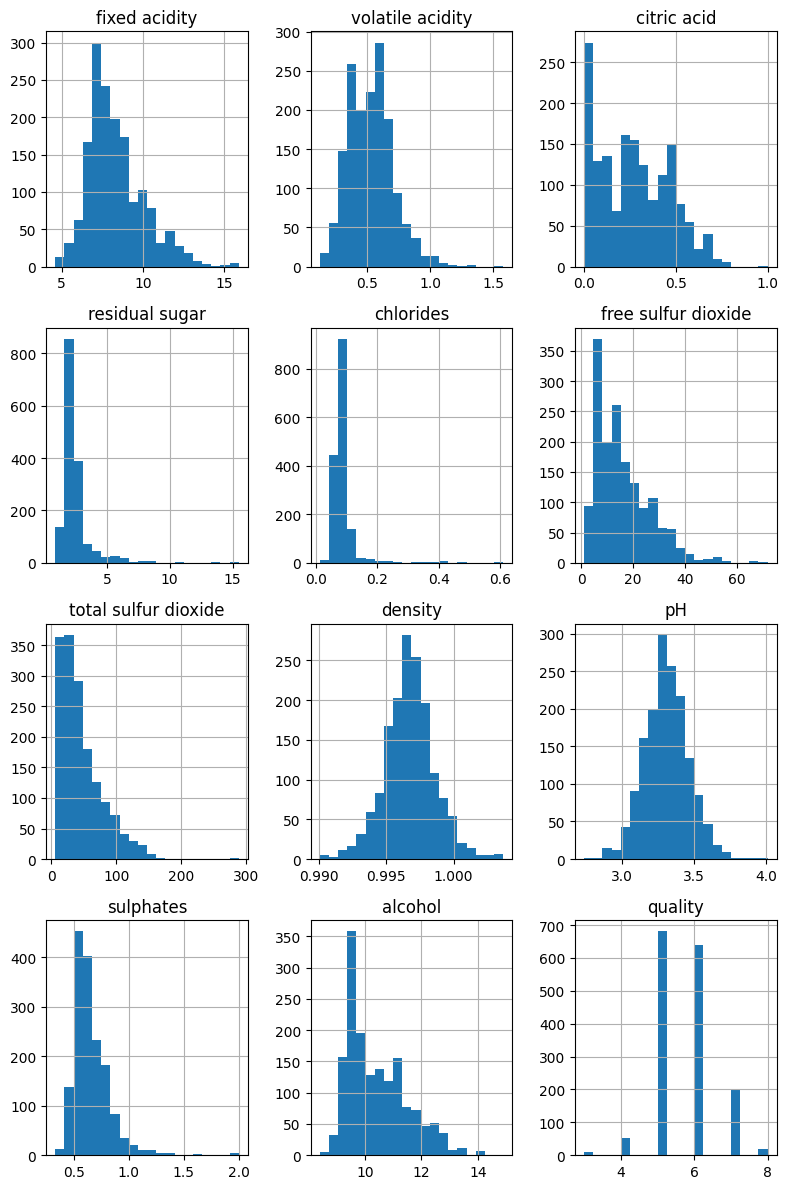

In [7]:
import matplotlib.pyplot as plt
df.hist(figsize=(8, 12), bins =20)
plt.tight_layout()
plt.plot()

<Axes: >

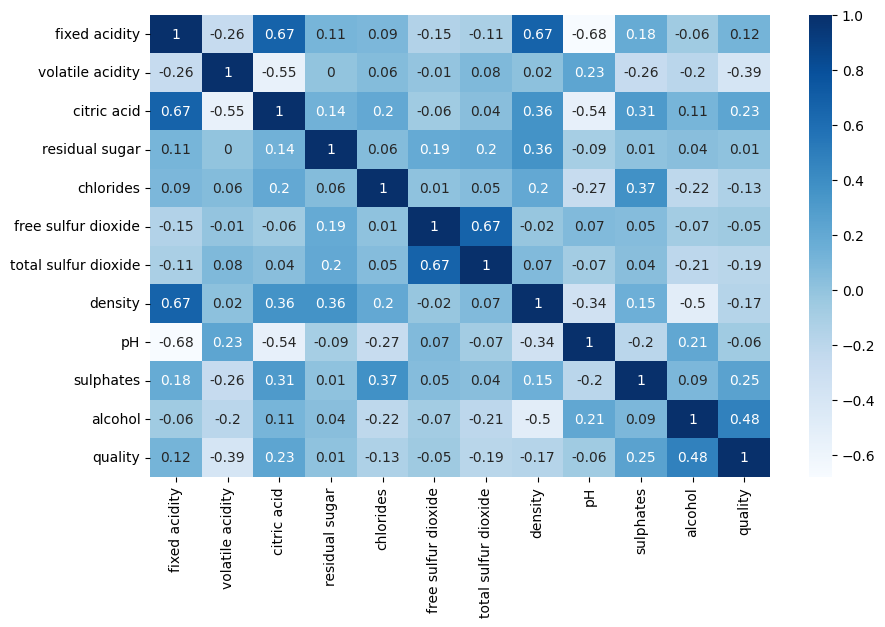

In [8]:
corr = df.corr()

import seaborn as sns

f, ax = plt.subplots(figsize=(10,6))
sns.heatmap(round(corr, 2), annot=True,ax=ax, cmap="Blues")

In [9]:
df.quality.value_counts()

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64

In [10]:
X = df.drop(columns='quality')
y = df.quality.apply(lambda x:0 if x <= 5 else 1)

In [11]:
y.value_counts(
)


quality
1    855
0    744
Name: count, dtype: int64

In [12]:
from sklearn.model_selection import train_test_split

x_train_val, x_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
x_train, x_Val, y_train, y_val = train_test_split(x_train_val, y_train_val, stratify=y_train_val, test_size=0.25, random_state=42)

In [13]:
x_train.shape

(959, 11)

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
param_grid = {
    'n_estimators':[100,200, 300,],
    'max_depth':[None, 10,20,30],
    #'min_samples_split':[None,2,5,10,20,50]
}

rf = RandomForestClassifier()
gridsearch = GridSearchCV(estimator = rf,param_grid=param_grid,cv=5, scoring='f1',n_jobs=-1)

gridsearch.fit(x_train_val, y_train_val)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'n_estimators': [100, 200, 300]},
             scoring='f1')

In [15]:
gridsearch.best_params_

{'max_depth': 30, 'n_estimators': 300}

In [16]:
gridsearch.best_score_

np.float64(0.8230259826914101)

In [17]:
gridsearch.cv_results_

{'mean_fit_time': array([0.5428205 , 1.31166892, 1.62719374, 0.43762522, 0.87743235,
        1.27037296, 0.50843396, 0.97511673, 1.68776274, 0.50918694,
        0.92262669, 1.39662452]),
 'std_fit_time': array([0.15258294, 0.4358369 , 0.47097056, 0.03233126, 0.03299631,
        0.07024331, 0.12076541, 0.20527928, 0.43917498, 0.09141781,
        0.08221421, 0.21589006]),
 'mean_score_time': array([0.02699089, 0.04019899, 0.04806318, 0.01663513, 0.02956252,
        0.03579288, 0.0206718 , 0.03205214, 0.04565477, 0.01890979,
        0.03354445, 0.02574325]),
 'std_score_time': array([0.01515281, 0.01398882, 0.01079549, 0.00153042, 0.00333175,
        0.00304083, 0.0033974 , 0.00225821, 0.01127581, 0.0025951 ,
        0.00900061, 0.00271223]),
 'param_max_depth': masked_array(data=[None, None, None, 10, 10, 10, 20, 20, 20, 30, 30, 30],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value=np.str_('?')

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(10, 300),
    'min_samples_split':randint(2,30),
    'min_samples_leaf': randint(1,10)
    
}
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter = 50, cv=5, scoring='f1', n_jobs=-1)

random_search.fit(x_train_val, y_train_val)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F27BA70FE0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F27C21CB60>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F27C21F950>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F27979C9B0>},
                   scoring='f1')

In [19]:
random_search.best_score_

np.float64(0.8092086541091021)

In [20]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 190,230)
    max_depth = trial.suggest_int('max_depth', 50,55)
    min_samples_split = trial.suggest_int('min_samples_split',2,4)
    min_samples_leaf = trial.suggest_int('min_samples_leaf',1,2)


    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    score = cross_val_score(rf, x_train_val, y_train_val, cv=5, scoring='f1').mean()

    return score


In [21]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

[I 2024-11-08 20:30:48,238] A new study created in memory with name: no-name-4460aaab-3ef5-4dcd-84b1-ffe6c4163758
[I 2024-11-08 20:30:50,457] Trial 0 finished with value: 0.8146526982151417 and parameters: {'n_estimators': 212, 'max_depth': 53, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8146526982151417.
[I 2024-11-08 20:30:52,745] Trial 1 finished with value: 0.8114733285794176 and parameters: {'n_estimators': 221, 'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8146526982151417.
[I 2024-11-08 20:30:54,898] Trial 2 finished with value: 0.8169775505708952 and parameters: {'n_estimators': 208, 'max_depth': 51, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.8169775505708952.
[I 2024-11-08 20:30:57,220] Trial 3 finished with value: 0.8120546914280954 and parameters: {'n_estimators': 223, 'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 2 with value

In [22]:
study.best_trial

FrozenTrial(number=21, state=1, values=[0.8249063903071123], datetime_start=datetime.datetime(2024, 11, 8, 20, 31, 35, 367851), datetime_complete=datetime.datetime(2024, 11, 8, 20, 31, 37, 302060), params={'n_estimators': 194, 'max_depth': 53, 'min_samples_split': 4, 'min_samples_leaf': 1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=230, log=False, low=190, step=1), 'max_depth': IntDistribution(high=55, log=False, low=50, step=1), 'min_samples_split': IntDistribution(high=4, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=2, log=False, low=1, step=1)}, trial_id=21, value=None)

In [23]:
study.best_params

{'n_estimators': 194,
 'max_depth': 53,
 'min_samples_split': 4,
 'min_samples_leaf': 1}

In [24]:
params = {'n_estimators': 202,
 'max_depth': 54,
 'min_samples_split': 4,
 'min_samples_leaf': 1}

rf= RandomForestClassifier(**params)

rf.fit(x_train, y_train)

y_pred_val = rf.predict(x_Val)

from sklearn.metrics import f1_score

f1_score(y_val, y_pred_val)


np.float64(0.8160919540229885)

In [25]:
from sklearn.metrics import confusion_matrix 

confusion_matrix(y_val, y_pred_val)

array([[114,  35],
       [ 29, 142]])

In [26]:
importances_df = pd.DataFrame({
    'feature':x_train.columns,
    'importances': rf.feature_importances_
})

importances_df

feature  importances
0          fixed acidity     0.070010
1       volatile acidity     0.115940
2            citric acid     0.059252
3         residual sugar     0.053236
4              chlorides     0.076442
5    free sulfur dioxide     0.054489
6   total sulfur dioxide     0.098191
7                density     0.091546
8                     pH     0.062291
9              sulphates     0.122313
10               alcohol     0.196289

<BarContainer object of 11 artists>

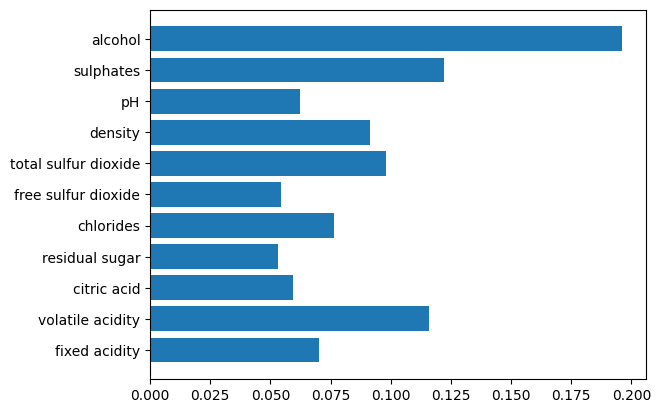

In [27]:
plt.barh(importances_df['feature'], importances_df['importances'])

In [29]:
from sklearn.inspection import PartialDependenceDisplay

features = ['alcohol', "sulphates", 'volatile_acidity']
PartialDependenceDisplay.from_estimator(rf, x_train, features=features, grid_resolution=50)

ValueError: Feature 'volatile_acidity' not in feature_names

In [ ]:
from sklearn.inspection import permutation_importance

perm_importance= permutation_importance(rf, x_Val, y_val, n_repeats=50, random_state=42)

perm_importance

{'importances_mean': array([0.018625 , 0.0324375, 0.0123125, 0.0099375, 0.0015625, 0.019    ,
        0.0365625, 0.0095625, 0.01025  , 0.076    , 0.0749375]),
 'importances_std': array([0.00785513, 0.01254507, 0.0069712 , 0.00797187, 0.00786234,
        0.00723058, 0.01095534, 0.00929991, 0.00640556, 0.0172577 ,
        0.01570592]),
 'importances': array([[ 0.025   ,  0.009375,  0.028125,  0.0125  ,  0.01875 ,  0.025   ,
          0.021875,  0.01875 ,  0.0125  ,  0.028125,  0.003125,  0.0125  ,
          0.01875 ,  0.028125,  0.0125  ,  0.015625,  0.0375  ,  0.0125  ,
          0.03125 ,  0.021875,  0.021875,  0.025   ,  0.0125  ,  0.009375,
          0.003125,  0.00625 ,  0.01875 ,  0.00625 ,  0.015625,  0.0125  ,
          0.01875 ,  0.034375,  0.034375,  0.015625,  0.025   ,  0.0125  ,
          0.01875 ,  0.021875,  0.0125  ,  0.01875 ,  0.015625,  0.0125  ,
          0.01875 ,  0.01875 ,  0.028125,  0.028125,  0.021875,  0.01875 ,
          0.01875 ,  0.0125  ],
        [ 0.02812

In [ ]:
perm_importance.importances_mean,perm_importance.importances_std


(array([0.018625 , 0.0324375, 0.0123125, 0.0099375, 0.0015625, 0.019    ,
        0.0365625, 0.0095625, 0.01025  , 0.076    , 0.0749375]),
 array([0.00785513, 0.01254507, 0.0069712 , 0.00797187, 0.00786234,
        0.00723058, 0.01095534, 0.00929991, 0.00640556, 0.0172577 ,
        0.01570592]))

<BarContainer object of 11 artists>

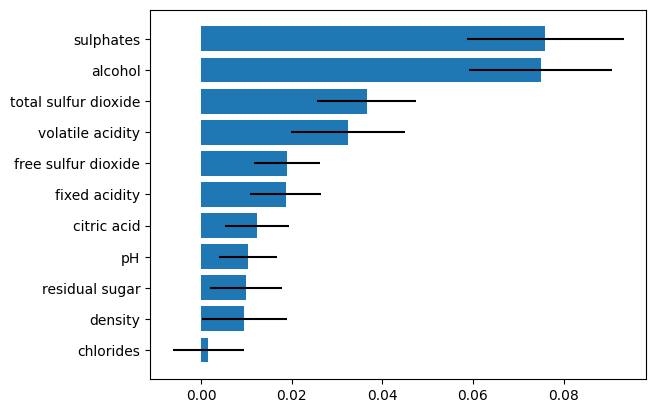

In [ ]:
perm_importance_df = pd.DataFrame({
    "feature":x_Val.columns,
    'importances_mean':perm_importance.importances_mean,
    'importances_std':perm_importance.importances_std
}).sort_values('importances_mean')
plt.barh(perm_importance_df.feature, perm_importance_df.importances_mean, xerr=perm_importance_df.importances_std)

In [ ]:
import shap

ImportError: Numba needs NumPy 2.0 or less. Got NumPy 2.1.

In [ ]:
import shap

i:\Apps\Anaconda Big\envs\excalibur\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
shap.initjs()
explainer = shap.Explainer(rf)
shap_values = explainer(x_Val)[:,:,1]
pd.DataFrame(shap_values)

ValueError: DataFrame constructor not properly called!

In [ ]:
y_val.mean

In [34]:
y_val_pred = rf.predict_proba(x_Val)
y_val_pred

array([[0.57088637, 0.42911363],
       [0.09845592, 0.90154408],
       [0.51164545, 0.48835455],
       [0.54447195, 0.45552805],
       [0.23481848, 0.76518152],
       [0.87367987, 0.12632013],
       [0.34009901, 0.65990099],
       [0.70965347, 0.29034653],
       [0.81905941, 0.18094059],
       [0.78860207, 0.21139793],
       [0.18630363, 0.81369637],
       [0.94413013, 0.05586987],
       [0.2220297 , 0.7779703 ],
       [0.42996228, 0.57003772],
       [0.17900754, 0.82099246],
       [0.4283239 , 0.5716761 ],
       [0.2120462 , 0.7879538 ],
       [0.2839934 , 0.7160066 ],
       [0.48770627, 0.51229373],
       [0.74899811, 0.25100189],
       [0.0759901 , 0.9240099 ],
       [0.31419142, 0.68580858],
       [0.44092409, 0.55907591],
       [0.42805281, 0.57194719],
       [0.67195898, 0.32804102],
       [0.42483498, 0.57516502],
       [0.94084158, 0.05915842],
       [0.93894389, 0.06105611],
       [0.18688119, 0.81311881],
       [0.30957096, 0.69042904],
       [0.

In [31]:
pd.DataFrame(shap_values, columns=x_Val.columns)

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0        -0.011391          0.000916    -0.009078       -0.000542   0.011943   
1         0.018397         -0.022456     0.030844        0.013391   0.014171   
2         0.011237         -0.020984    -0.002853       -0.009749   0.000812   
3        -0.026617          0.097843    -0.019790       -0.000745   0.026636   
4        -0.017740          0.025619     0.004133        0.006964   0.012218   
..             ...               ...          ...             ...        ...   
315       0.037128          0.091696    -0.030391       -0.008434   0.020119   
316       0.015727          0.015895    -0.036311       -0.025224  -0.042281   
317       0.018223         -0.056781     0.018428        0.009080   0.045061   
318      -0.047621          0.035238    -0.009243       -0.001908   0.010146   
319      -0.006256          0.200038    -0.014614        0.012390  -0.044280   

     free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0               0.016750              0.056734 -0.053359  0.005276  -0.029649   
1               0.010121              0.032201  0.072339  0.009721   0.045950   
2               0.012049              0.010930  0.060033 -0.003876  -0.203343   
3              -0.023056             -0.036627 -0.016721 -0.014050   0.013792   
4               0.003661              0.053571 -0.033312 -0.001137   0.054704   
..                   ...                   ...       ...       ...        ...   
315             0.008958              0.036440 -0.016299  0.003306   0.089651   
316            -0.008756             -0.004424 -0.037860 -0.005564  -0.095146   
317             0.015970              0.027076  0.107615  0.003981  -0.014967   
318             0.006914              0.030896 -0.041144 -0.035833   0.015700   
319            -0.000920              0.027762 -0.001036  0.006707  -0.010589   

      alcohol  
0   -0.092732  
1    0.142619  
2    0.099853  
3   -0.079382  
4    0.122256  
..        ...  
315 -0.021619  
316  0.003046  
317  0.262777  
318  0.223648  
319 -0.117309  

[320 rows x 11 columns]

In [32]:
x_Val.shape

(320, 11)

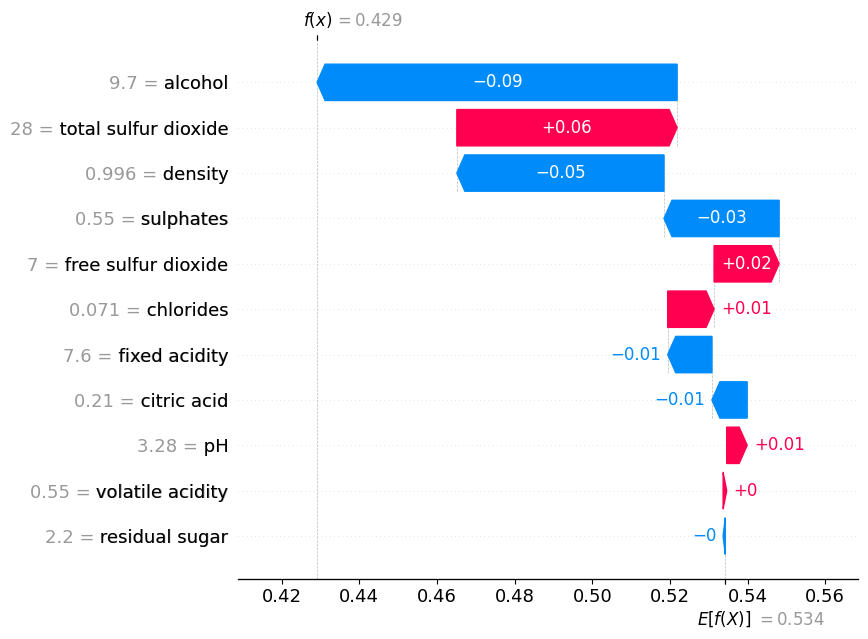

In [39]:
shap.plots.waterfall(shap_values[0], max_display=14)
